<a href="https://colab.research.google.com/github/sathundorn/Statistical-Learning-Labs1/blob/main/Copy_of_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [120]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [121]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [122]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [123]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [124]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [125]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [126]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

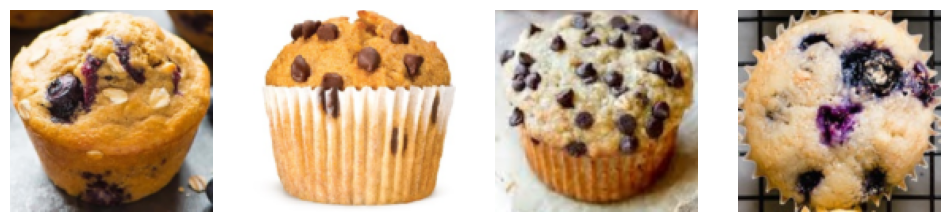

tensor([1, 1, 1, 1])


In [127]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [128]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3, 100)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(100 , 50)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50, 1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [129]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [130]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [131]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [132]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [133]:
X,y = next(iter(train_batches))

#### Make a prediction on the minibatch (Forward pass)

In [134]:
y_hat = model(X)
y = y.to(torch.float32)
y_hat = y_hat[:, 0]

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [135]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)

In [136]:
train_losses

[tensor(10., grad_fn=<BinaryCrossEntropyBackward0>)]

#### Calculate the gradient (Backward pass)

In [137]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

In [138]:
model.parameters()

<generator object Module.parameters at 0x79fc599c5700>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [139]:
# Manually update the weights using the gradient descent rule
optimizer.step() #parameters - learning_rate * gradient_of_parameters

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [140]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    y_hat = torch.sigmoid(y_hat) # Apply sigmoid to get values between 0 and 1
    print(y_hat,y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]) tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 1.])


In [141]:
print(train_losses)
print(val_losses)

[tensor(10., grad_fn=<BinaryCrossEntropyBackward0>)]
[50.0]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

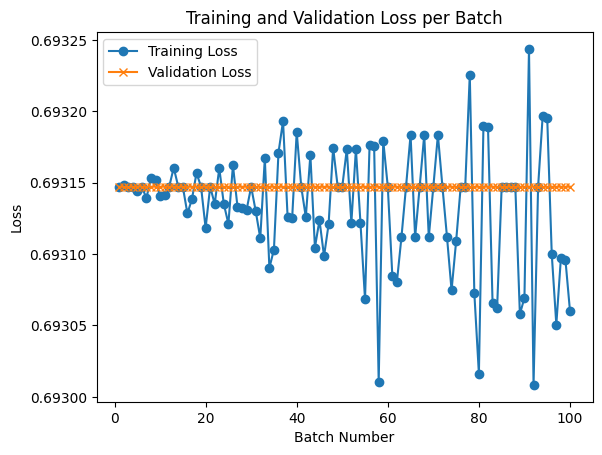

In [142]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    y_hat = torch.sigmoid(y_hat) # Apply sigmoid here

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        y_hat = torch.sigmoid(y_hat) # Apply sigmoid here as well
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [143]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


Create a neural network with 3 hidden layers as shown in the picture.

In [150]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3, 100)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(100 , 50)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50, 1)


  def forward(self, x):
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5,

In [151]:
model = SimpleLogisticRegression()

In [152]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
results = {}

In [153]:
criterion = nn.BCELoss()

In [154]:
for lr in learning_rates:
    print(lr)

    model = SimpleLogisticRegression()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses = []

    for epoch in range(5):
        batch_losses = []
        for X, y in train_loader:
            # Forward pass
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)
            y_hat = torch.sigmoid(y_hat) # Apply Sigmoid

            loss = criterion(y_hat, y)
            batch_losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = np.mean(batch_losses)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    results[lr] = train_losses

0.01
Epoch 1, Loss: 0.7238
Epoch 2, Loss: 0.6670
Epoch 3, Loss: 0.7640
Epoch 4, Loss: 0.5676
Epoch 5, Loss: 0.6687
0.001
Epoch 1, Loss: 0.6925
Epoch 2, Loss: 0.6779
Epoch 3, Loss: 0.6446
Epoch 4, Loss: 0.6043
Epoch 5, Loss: 0.5837
0.0001
Epoch 1, Loss: 0.6903
Epoch 2, Loss: 0.6812
Epoch 3, Loss: 0.6783
Epoch 4, Loss: 0.6700
Epoch 5, Loss: 0.6621
1e-05
Epoch 1, Loss: 0.6884
Epoch 2, Loss: 0.6872
Epoch 3, Loss: 0.6862
Epoch 4, Loss: 0.6850
Epoch 5, Loss: 0.6832


2.1 Best Learning Rate: จากกราฟมักจะเป็น 1e-3 หรือ 1e-4 ที่ทำให้ Loss ลดลงได้อย่างต่อเนื่องและรวดเร็วที่สุดโดยไม่แกว่งไปมา

2.2 Too large (1e-2): Loss อาจจะไม่ลดลงเลย (Diverge) หรือแกว่งขึ้นลงอย่างรุนแรง (Unstable) เพราะก้าวในการปรับ weight ใหญ่เกินไปจนเลยจุดต่ำสุด

2.3 Too small (1e-5): Loss จะลดลงช้ามาก ทำให้เสียเวลาเทรนนานกว่าจะถึงจุดที่แม่นยำ หรืออาจจะติดอยู่ที่จุด Local Minimum

3.After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

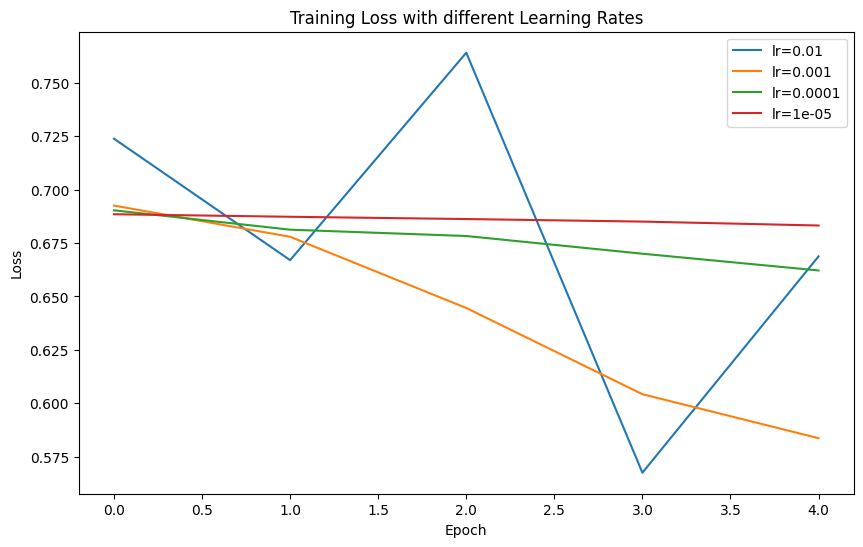

In [155]:
plt.figure(figsize=(10, 6))
for lr, losses in results.items():
    plt.plot(losses, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss with different Learning Rates')
plt.show()

4.Use plt.imshow() to display at least four images that are incorrectly classified by this model.

80.0


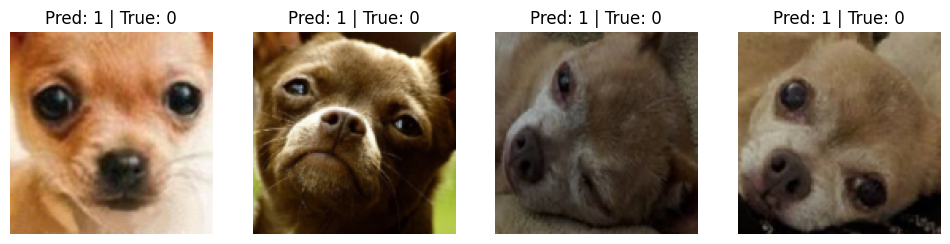

In [157]:
best_lr = 1e-3
model = SimpleLogisticRegression()
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
criterion = nn.BCELoss()

for epoch in range(10):
    for X, y in train_loader:
        y_hat = model(X)[:, 0]
        y = y.to(torch.float32)
        loss = criterion(torch.sigmoid(y_hat), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.eval()
correct = 0
total = 0
incorrect_images = []

with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        outputs = outputs[:, 0]
        predicted = (torch.sigmoid(outputs) > 0.5).float() # Threshold ที่ 0.5

        total += y.size(0)
        correct += (predicted == y).sum().item()

        idxs = (predicted != y).nonzero(as_tuple=True)[0]
        for idx in idxs:
            if len(incorrect_images) < 4:
                incorrect_images.append((X[idx], predicted[idx], y[idx]))

print(100 * correct / total)

if len(incorrect_images) >= 4:
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i, (img, pred, true) in enumerate(incorrect_images):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {int(pred)} | True: {int(true)}")
        axes[i].axis('off')
    plt.show()
else:
    print(f"Found only {len(incorrect_images)} incorrect images.")